# Velocity Distributions 
currently trying out sum of gaussians with 2 different sigmas - $10^{13.5} - 10^{14} M_\odot$

In [1]:
import h5py
import numpy as np
from matplotlib.pyplot import figure,show
from swiftsimio import load
import pandas as pd
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.optimize import root, minimize
from lmfit.models import LorentzianModel, VoigtModel, GaussianModel,LognormalModel
from scipy.integrate import quad

from scipy.ndimage import gaussian_filter1d


In [2]:
path_hydro= "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_hydro, "r") as handle:
    TotalMass= handle["ExclusiveSphere/100kpc/TotalMass"][:]
    COMvelocity=handle["ExclusiveSphere/100kpc/CentreOfMassVelocity"][:]
    Trackid=handle["InputHalos/HBTplus/TrackId"][:]
    HOSTFOFID=handle["InputHalos/HBTplus/HostFOFId"][:]
    HaloCatalogueIndex=handle["InputHalos/HaloCatalogueIndex"][:]
    HOSTHALOINDEX=handle["SOAP/HostHaloIndex"][:]
    FOFMass=handle["InputHalos/FOF/Masses"][:]
    NoofBoundParticles=handle["InputHalos/NumberOfBoundParticles"][:]
    NoofDMParticles=handle["ExclusiveSphere/100kpc/NumberOfDarkMatterParticles"][:]
    COM=handle["ExclusiveSphere/100kpc/CentreOfMass"][:]
    MaxCircularVel=handle["BoundSubhalo/MaximumCircularVelocity"][:]
    LastMaxCircularVel=handle["InputHalos/HBTplus/LastMaxVmaxPhysical"][:]
    LastMaxMass=handle["InputHalos/HBTplus/LastMaxMass"][:]

In [3]:
df = pd.DataFrame({
    'HOST_FOF' :  HOSTFOFID,
    'HostHaloIndex':HOSTHALOINDEX, # -1 for central halos
    'Catalogue Index': HaloCatalogueIndex,
    'Track ID' : Trackid,
    'mass':TotalMass,
    'FOFMass':FOFMass,
    'COM v- x':COMvelocity[:,0],
    'COM v- y':COMvelocity[:,1],
    'COM v- z':COMvelocity[:,2],
    'COM - x':COM[:,0],
    'COM - y':COM[:,1],
    'COM - z':COM[:,2],
    'Bound Particles No':NoofBoundParticles,
    'DM Particles No': NoofDMParticles,
    'Max Circular Vel':MaxCircularVel,
    'Last Max Mass':LastMaxMass,
    'Last Max Circular Vel':LastMaxCircularVel
})
df['INDEX_HOST_HALOS']=np.asarray(df.index)

DF_BOUND_NO_FILTERED= df[df['Bound Particles No']>100]
display(df)
display(DF_BOUND_NO_FILTERED.sort_values(by='Last Max Mass'))

,HOST_FOF,HostHaloIndex,Catalogue Index,Track ID,mass,FOFMass,COM v- x,COM v- y,COM v- z,COM - x,COM - y,COM - z,Bound Particles No,DM Particles No,Max Circular Vel,Last Max Mass,Last Max Circular Vel,INDEX_HOST_HALOS
0,1039187,-1,646,32298,168.000000,1164.000000,-202.030396,140.269531,-579.830444,23.734835,17.830045,24.049015,1356,274,284.000,633.000000,346.000,0
1,1039314,-1,1512,96387,208.250000,1120.000000,-299.430420,118.769531,-304.930420,19.606055,21.428705,15.315335,2452,338,317.500,1134.000000,355.000,1
2,1041401,-1,1516,96393,199.000000,635.000000,-620.230408,279.169556,-632.630432,1.985425,14.544495,15.552605,1269,323,319.000,581.000000,380.500,2
3,1040958,-1,1768,240562,221.500000,732.000000,-303.430420,255.969604,-132.930420,20.112205,8.779495,3.317025,1522,365,329.500,717.000000,391.000,3
4,1038214,-1,1851,240661,376.500000,1846.000000,-343.330444,307.469604,-231.930420,15.549465,10.733535,7.873675,4111,604,415.500,1780.000000,450.500,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15329648,1192733,-1,32187281,32187281,10.046875,17.031250,223.907593,678.007568,-307.092407,972.009585,977.686395,972.474395,31,17,93.500,15.234375,93.500,15329648
15329649,1195874,-1,32187284,32187284,7.671875,15.546875,237.707642,622.907593,-439.292389,987.985825,980.917505,997.726705,30,13,102.000,13.750000,102.000,15329649
15329650,1199190,-1,32187288,32187288,7.109375,15.437500,288.507568,838.807617,-438.092377,973.485265,981.180935,993.807645,33,12,108.875,15.437500,108.875,15329650
15329651,1202840,-1,32187293,32187293,5.656250,16.718750,20.507629,778.907593,-166.492371,979.062535,990.945435,969.533915,29,10,80.125,15.484375,80.125,15329651


,HOST_FOF,HostHaloIndex,Catalogue Index,Track ID,mass,FOFMass,COM v- x,COM v- y,COM v- z,COM - x,COM - y,COM - z,Bound Particles No,DM Particles No,Max Circular Vel,Last Max Mass,Last Max Circular Vel,INDEX_HOST_HALOS
8472598,8087048,-1,22771980,18090799,19.40625,30.65625,-286.246277,101.453796,-154.346252,559.172696,751.987246,273.108816,104,25,214.75,30.00000,230.25,8472598
13334876,14832730,-1,32113414,13492446,21.59375,43.50000,293.997803,-5.102295,-56.702148,854.895643,801.625913,936.549233,103,28,201.25,30.25000,201.25,13334876
6455185,9371757,-1,11377192,23023889,22.25000,43.93750,-66.388062,-90.988159,-240.088135,421.226928,327.730118,522.041418,101,32,183.75,30.50000,204.75,6455185
13962863,15626354,-1,24848962,28402542,20.65625,30.59375,-548.704773,9.095276,-174.704773,912.419218,142.270878,370.907528,102,29,195.50,30.59375,195.25,13962863
4062038,3668959,-1,10427782,28553167,19.90625,43.75000,-40.375610,-222.575562,-103.775635,270.566144,426.890044,81.681154,102,28,211.75,30.62500,220.50,4062038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567945,7765587,-1,1039297,250091,2840.00000,281600.00000,303.553467,-243.146729,-175.046631,113.749729,215.865499,539.339339,625625,4111,1884.00,217856.00000,1884.00,1567945
14917267,779387,-1,24799266,26459,2636.00000,281600.00000,-264.143799,-545.243896,-366.043945,995.175013,110.849003,262.340493,656697,3679,1788.00,229376.00000,1910.00,14917267
8991449,8541465,-1,23526495,6743,2344.00000,385024.00000,449.266846,430.666748,-603.933105,579.200632,872.581932,832.994262,713100,3567,1750.00,245248.00000,1750.00,8991449
754008,1292704,-1,5647883,289106,2948.00000,334336.00000,-91.134277,291.265625,333.165771,46.260567,532.970787,769.992577,718699,4382,1760.00,251136.00000,1766.00,754008


In [ ]:

#trial new version. if it does not work, go with the old version!
def final_velocity(df, lower_mass=-1, upper_mass=-1):
    if upper_mass == -1:
        M_bin = df[df['FOFMass'] >= lower_mass]
    elif lower_mass == -1:
        M_bin = df[df['FOFMass'] < upper_mass]
    else:
        M_bin = df[(df['FOFMass'] >= lower_mass) & (df['FOFMass'] < upper_mass)]

    HOSTINDICES = M_bin.index.to_numpy()
    print(f"Number of host halos: {len(HOSTINDICES)}")

    # Filter subhalos of halos
    filtereddf = df[df['HostHaloIndex'].isin(HOSTINDICES)].sort_values(by='HostHaloIndex')
    filtereddf['freq'] = filtereddf.groupby('HostHaloIndex')['HostHaloIndex'].transform('count')

    # Number of subhalos per halo
    df2 = filtereddf.groupby('HostHaloIndex')['freq'].mean()
    FINALHOSTINDICES = df2.index.to_numpy()
    offsets = df2.values.astype(int)

    # Keep only halos corresponding to subhalos
    M_bin = M_bin[M_bin['INDEX_HOST_HALOS'].isin(FINALHOSTINDICES)]

    host_vel_stack = M_bin[['COM v- x', 'COM v- y', 'COM v- z']].to_numpy()
    host_pos_stack = M_bin[['COM - x', 'COM - y', 'COM - z']].to_numpy()
    subhalo_vel_stack = filtereddf[['COM v- x', 'COM v- y', 'COM v- z']].to_numpy()
    subhalo_pos_stack = filtereddf[['COM - x', 'COM - y', 'COM - z']].to_numpy()

    host_vel_repeat = np.repeat(host_vel_stack, offsets, axis=0)
    host_pos_repeat = np.repeat(host_pos_stack, offsets, axis=0)

    # Compute relative velocities and positions
    subhalo_relvel = subhalo_vel_stack - host_vel_repeat
    subhalo_rel = host_pos_repeat - subhalo_pos_stack

    final_velx, final_vely, final_velz = subhalo_relvel.T
    final_relx, final_rely, final_relz = subhalo_rel.T
    total_vel_xyz = subhalo_relvel.ravel()

    return final_velx, final_vely, final_velz, total_vel_xyz, final_relx, final_rely, final_relz


In [5]:
# Old version:
# 
# def final_velocity(df,lower_mass,upper_mass):
#     #filtering FOF groups based on mass
#     if upper_mass==-1:
#         M_bin=df[df['FOFMass']>=lower_mass] 
#     elif lower_mass==-1:
#         M_bin=df[(df['FOFMass']<upper_mass)]
#     else:
#         M_bin=df[(df['FOFMass']>=lower_mass)& (df['FOFMass']<upper_mass)] 
#     HOSTINDICES=np.asarray(M_bin.index) #indices of hosts
#     display(M_bin)
#     print((HOSTINDICES)) #check number of host halos
#     filtereddf=df.loc[df['HostHaloIndex'].isin(HOSTINDICES)].sort_values(by='HostHaloIndex') #filters all subhalos within each FOF group in M_bin
#     print(min(filtereddf['HostHaloIndex']))
#     print(len(np.unique(np.array(filtereddf['HostHaloIndex']))))
#     # finding number of subhalos in each FOF group
#     filtereddf['freq'] = filtereddf.groupby('HostHaloIndex')['HostHaloIndex'].transform('count')
#     display(filtereddf)
#     df2=filtereddf.groupby('HostHaloIndex')['freq'].mean()
#     FINALHOSTINDICES=df2.index
#     offsets=df2.values.astype(int)

#     M_bin=M_bin[M_bin['INDEX_HOST_HALOS'].isin(FINALHOSTINDICES)] #making sure that the groups corresponding to the subhalos are used 
#     HOSTHALO_INDICES=np.asarray(M_bin.index)

#     #center of mass vel of each group
#     HOSTHALOVEL_X=np.asarray(M_bin['COM v- x'])
#     HOSTHALOVEL_Y=np.asarray(M_bin['COM v- y'])
#     HOSTHALOVEL_Z=np.asarray(M_bin['COM v- z'])
#     #positions
#     HOSTHALO_X=np.asarray(M_bin['COM - x'])
#     HOSTHALO_Y=np.asarray(M_bin['COM - y'])
#     HOSTHALO_Z=np.asarray(M_bin['COM - z'])
#     #center of mass vel of each subhalo
#     SUBHALO_X=np.asarray(filtereddf['COM v- x'])
#     SUBHALO_Y=np.asarray(filtereddf['COM v- y'])
#     SUBHALO_Z=np.asarray(filtereddf['COM v- z'])
    
#     #subhalo positions
#     SUBHALO_x=np.asarray(filtereddf['COM - x'])
#     SUBHALO_y=np.asarray(filtereddf['COM - y'])
#     SUBHALO_z=np.asarray(filtereddf['COM - z'])

#     #relative quantities
#     subhalo_relvel_x=np.zeros(len(SUBHALO_X))
#     subhalo_relvel_y=np.zeros(len(SUBHALO_X))
#     subhalo_relvel_z=np.zeros(len(SUBHALO_X))
    
#     subhalo_rel_x=np.zeros(len(SUBHALO_X))
#     subhalo_rel_y=np.zeros(len(SUBHALO_X))
#     subhalo_rel_z=np.zeros(len(SUBHALO_X))
#     print(len(HOSTHALO_INDICES), len(HOSTHALOVEL_X)) #check 
    
#     count_lower=0
#     count_upper=0
#     for i in range(len(HOSTHALO_INDICES)):
#         CENTRAL_VELX=HOSTHALOVEL_X[i]
#         CENTRAL_VELY=HOSTHALOVEL_Y[i]
#         CENTRAL_VELZ=HOSTHALOVEL_Z[i]
#         CENTRAL_X=HOSTHALO_X[i]
#         CENTRAL_Y=HOSTHALO_Y[i]
#         CENTRAL_Z=HOSTHALO_Z[i]
#         count_upper+=offsets[i]
#         # print(count_lower,count_upper)
#         subhalo_relvel_x[count_lower:count_upper]=SUBHALO_X[count_lower:count_upper]-CENTRAL_VELX
#         subhalo_relvel_y[count_lower:count_upper]=SUBHALO_Y[count_lower:count_upper]-CENTRAL_VELY
#         subhalo_relvel_z[count_lower:count_upper]=SUBHALO_Z[count_lower:count_upper]-CENTRAL_VELZ
#         subhalo_rel_x[count_lower:count_upper]=CENTRAL_X- SUBHALO_x[count_lower:count_upper]
#         subhalo_rel_y[count_lower:count_upper]=CENTRAL_Y-SUBHALO_y[count_lower:count_upper]
#         subhalo_rel_z[count_lower:count_upper]=CENTRAL_Z-SUBHALO_z[count_lower:count_upper]
#         count_lower+=offsets[i]
    
#     print(count_lower,count_upper)
    
#     final_velx=subhalo_relvel_x
#     final_vely=subhalo_relvel_y
#     final_velz=subhalo_relvel_z
#     final_relx=subhalo_rel_x
#     final_rely=subhalo_rel_y
#     final_relz=subhalo_rel_z
#     total_vel_xyz=np.concatenate((final_velx,final_vely,final_velz), axis=None) 

#     return final_velx,final_vely,final_velz,total_vel_xyz,final_relx,final_rely,final_relz




### Maximum likelihood estimation

In [6]:
def mod_gaussian(x,sigma,sigma1,lambda_):
    return ((1-lambda_)* (np.exp(-(x)**2 / (2 * sigma**2)) /sigma ) +lambda_*np.exp(-((x)**2/(2*sigma1**2)))/sigma1)/ (np.sqrt(2*np.pi))

def mod_gaussian_integral(sigma,sigma1,lambda_,x_i,x_f):
    integral,_=quad(lambda x: mod_gaussian(x,sigma,sigma1,lambda_), x_i, x_f) #quad is not necessary, romberg is better
    return integral
    

def mod_gaussian_neg_log_likelihood_binned(params, bin_edges, bin_heights, bin_width):
    sigma,sigma1,lambda_=params
    hist_area=np.sum(bin_heights) 
    fit_integral =1
    A=hist_area/ fit_integral
    neg_log_L=0
    for i in range(1,len(bin_edges)):
        f_b= A* mod_gaussian_integral(sigma,sigma1,lambda_,bin_edges[i-1],bin_edges[i])
        if f_b<=0:
            return 10**11
        n_b=bin_heights[i-1] * bin_width
        neg_log_L+= f_b - (n_b * np.log(f_b))
    return neg_log_L

In [7]:


def plot_distribution_gaussian_mod(f,params,data,bins,distname,binno):
    
    bin_heights, bin_edges = np.histogram(data, bins=bins, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width= bin_edges[1] - bin_edges[0] 
    bin_widths = np.diff(bin_edges)  # The width of each bin
    number_density = bin_heights / bin_widths  # Normalize by bin width
    # Plot the histogram
    fig=figure(figsize=(7,7))
    frame=fig.add_subplot(1,1,1)
    frame.set_xlabel('Velocity difference v', fontsize=16)
    frame.set_ylabel('Number of galaxies per v', fontsize=16)
    frame.bar(bin_centers, number_density, width=bin_width, align='center')
    DAT=np.linspace(np.min(data),np.max(data),1000)
    sigma,sigma1,lambda_=params 
    hist_area=np.sum(bin_heights)
    print(hist_area)
    fit_integral = 1 #since we're using a normalized function
    A=hist_area/ fit_integral
    print(A)
    frame.plot(DAT,A*f(DAT,sigma,sigma1,lambda_),'-', label=f"{distname},\nN={hist_area:.0f}",color='red')
    # frame.set_yscale("log")
    frame.legend(fontsize=12.5, loc="upper right")
    frame.tick_params(axis='both', which='major',length=6, width=2,labelsize=14)
    # fig.savefig(f'M13_5_14_bin_{binno}.pdf', dpi=700)
    show()


In [8]:
M15_final_velx,M15_final_vely,M15_final_velz,M15_total_Vel,M15_final_x,M15_final_y,M15_final_z=final_velocity(DF_BOUND_NO_FILTERED,10**3.5,10**4)

Number of halos: 44270


In [19]:
M15_total_Vel

array([ -68.9671 ,  108.83295, -393.06714, ..., -517.6    ,  582.     ,
        -93.89996], shape=(609762,), dtype=float32)

In [9]:
df_scale=pd.DataFrame({
    'Relative pos - x':M15_final_x,
    'Relative pos - y':M15_final_y,
    'Relative pos - z':M15_final_z,
    'Relative radial distance':np.sqrt(M15_final_x**2+M15_final_y**2+M15_final_z**2),
    'Relative velocity - x':M15_final_velx,
    'Relative velocity - y':M15_final_vely,
    'Relative velocity - z':M15_final_velz,
})

df2 = df_scale

In [ ]:
df2

In [10]:
df01=df2[df2['Relative radial distance']<0.1]
vel_01=np.concatenate((df01['Relative velocity - x'],df01['Relative velocity - y'],df01['Relative velocity - z']), axis=None) 

df05=df2[(df2['Relative radial distance'] > 0.1) & (df2['Relative radial distance'] < 0.2)]
vel_07=np.concatenate((df05['Relative velocity - x'],df05['Relative velocity - y'],df05['Relative velocity - z']), axis=None) 

df10=df2[(df2['Relative radial distance']>0.2) & (df2['Relative radial distance'] < 0.23)]
vel_10=np.concatenate((df10['Relative velocity - x'],df10['Relative velocity - y'],df10['Relative velocity - z']), axis=None)

df11=df2[(df2['Relative radial distance']>0.23) & (df2['Relative radial distance'] < 0.29)]
vel_11=np.concatenate((df11['Relative velocity - x'],df11['Relative velocity - y'],df11['Relative velocity - z']), axis=None)

df12=df2[(df2['Relative radial distance']>0.29) & (df2['Relative radial distance'] < 0.32)]
vel_12=np.concatenate((df12['Relative velocity - x'],df12['Relative velocity - y'],df12['Relative velocity - z']), axis=None)

df13=df2[(df2['Relative radial distance']>0.32) & (df2['Relative radial distance'] < 0.36)]
vel_13=np.concatenate((df13['Relative velocity - x'],df13['Relative velocity - y'],df13['Relative velocity - z']), axis=None)

df14=df2[(df2['Relative radial distance']>0.36) & (df2['Relative radial distance'] < 0.4)]
vel_14=np.concatenate((df14['Relative velocity - x'],df14['Relative velocity - y'],df14['Relative velocity - z']), axis=None)

df15=df2[(df2['Relative radial distance'] > 0.40) & (df2['Relative radial distance'] < 0.50)]
vel_15=np.concatenate((df15['Relative velocity - x'],df15['Relative velocity - y'],df15['Relative velocity - z']), axis=None) 

df16=df2[(df2['Relative radial distance'] > 0.50) & (df2['Relative radial distance'] < 0.60)]
vel_16=np.concatenate((df16['Relative velocity - x'],df16['Relative velocity - y'],df16['Relative velocity - z']), axis=None) 

df17=df2[(df2['Relative radial distance'] > 0.60) & (df2['Relative radial distance'] < 0.80)]
vel_17=np.concatenate((df10['Relative velocity - x'],df17['Relative velocity - y'],df17['Relative velocity - z']), axis=None)

df20=df2[(df2['Relative radial distance'] > 0.80) & (df2['Relative radial distance'] < 1.0)]
vel_20=np.concatenate((df20['Relative velocity - x'],df20['Relative velocity - y'],df20['Relative velocity - z']), axis=None) 

df23=df2[(df2['Relative radial distance'] > 1.0) & (df2['Relative radial distance'] < 1.2)]
vel_23=np.concatenate((df23['Relative velocity - x'],df23['Relative velocity - y'],df23['Relative velocity - z']), axis=None) 

df25=df2[(df2['Relative radial distance'] > 1.2) & (df2['Relative radial distance'] < 1.4)]
vel_25=np.concatenate((df25['Relative velocity - x'],df25['Relative velocity - y'],df25['Relative velocity - z']), axis=None) 

df27=df2[(df2['Relative radial distance'] > 1.4) & (df2['Relative radial distance'] < 1.6)]
vel_27=np.concatenate((df27['Relative velocity - x'],df27['Relative velocity - y'],df27['Relative velocity - z']), axis=None) 
  
df30=df2[(df2['Relative radial distance'] > 1.6) & (df2['Relative radial distance'] < 1.8)]
vel_30=np.concatenate((df30['Relative velocity - x'],df30['Relative velocity - y'],df30['Relative velocity - z']), axis=None) 

df40=df2[(df2['Relative radial distance'] > 1.8) & (df2['Relative radial distance'] < 2.0)]
vel_40=np.concatenate((df40['Relative velocity - x'],df40['Relative velocity - y'],df40['Relative velocity - z']), axis=None) 

df45=df2[(df2['Relative radial distance'] > 2.0) & (df2['Relative radial distance'] < 2.2)]
vel_45=np.concatenate((df45['Relative velocity - x'],df45['Relative velocity - y'],df45['Relative velocity - z']), axis=None) 

df47=df2[(df2['Relative radial distance'] > 2.2) & (df2['Relative radial distance'] < 2.7)]
vel_47=np.concatenate((df47['Relative velocity - x'],df47['Relative velocity - y'],df47['Relative velocity - z']), axis=None) 


df50=df2[(df2['Relative radial distance'] > 2.7) & (df2['Relative radial distance'] < 5)]
vel_50=np.concatenate((df50['Relative velocity - x'],df50['Relative velocity - y'],df50['Relative velocity - z']), axis=None) 

# print(len(vel_01),len(vel_07),len(vel_10),len(vel_11),len(vel_12),len(vel_13),len(vel_14),len(vel_15),len(vel_16),len(vel_17),len(vel_20),len(vel_25),len(vel_27),len(vel_30),len(vel_40),len(vel_45),len(vel_47),len(vel_50))


In [17]:
vel_10

array([-109.     ,  -34.80005,  213.10004, ..., -899.10004, -522.9    ,
         88.80005], shape=(12954,), dtype=float32)

In [11]:
def fit_modified_gaussian(data,bins,initial_guess,bounds, neg_log_likelihood_func,plot_func=None,dist_func=None,distname='Modified Gaussian',binno=1):
    """
    Fits a modified Gaussian distribution using minimize (scipy.optimize) to binned data and plots the result.

    Input:
    data : Input peculiar velocity difference data to fit.
    bins : [int] Number of histogram bins.
    initial_guess : Initial guess for the parameters.
    bounds :  Bounds for the parameters .
    neg_log_likelihood_func : Negative log_likelihood function to minimize (negative log-likelihood). Must use (bin_edges, bin_heights, bin_width, result.x).
    plot_func : Function to plot the results. Must use (dist_func, params, data, bins, distname, binno).
    dist_func :  optional. Distribution function to be used while plotting.
    distname : [str] optional.  Name of the distribution to display in the plot.
    binno : [int or str] optional.  Identifier of the bin for labeling.

    Returns:
    result : The optimization result object from minimize.
    """
    
    # Compute histogram
    bin_heights, bin_edges = np.histogram(data, bins=bins, density=False)
    bin_width = bin_edges[1] - bin_edges[0]

    # Optimize
    result = minimize(
        neg_log_likelihood_func,
        initial_guess,
        args=(bin_edges, bin_heights, bin_width),
        bounds=bounds
    )

    print("Optimized parameters:", result.x)
    print(result)

    # Plot if function provided
    if plot_func and dist_func:
        plot_func(dist_func, result.x, data, bins=bins, distname=distname, binno=binno)

    return result


In [12]:

def fit_and_plot_multiple_gaussians(datasets, bins, initial_guesses, bounds=[(1e-10, None), (1e-10, None), (0.1, None)],neg_log_likelihood_func=None,plot_func=None,dist_func=None,distname='Modified Gaussian',bin_labels=None
):
    """
    Fits a modified Gaussian distribution to multiple datasets, plots each result,
    and returns a dictionary of optimization results.

    Input:
    datasets : List of peculiar velocity difference datasets to fit.
    bins : [int] Number of histogram bins.
    initial_guesses : [list or list of lists]
        If single list-> will be used for all datasets.
        If list of lists-> each sublist must be an initial guess for corresponding dataset.
    bounds : [list or list of lists]
        If single list-> will be used for all datasets.
        If list of lists-> each sublist must be an initial guess for corresponding dataset.
    neg_log_likelihood_func :  Negative log-likelihood function to minimize .
    plot_func :  Function to plot the model with best-fit parameters and the histogram of the underlying data for each dataset.
    dist_func :distribution function to be used within plot_func.
    distname : [str, optional] Name of the distribution to display in plot(s).
    bin_labels : [list of str or int, optional] List of labels for each dataset. If None, indices 01,02... will be assigned.

    Returns:
    results : [dictionary] {label: result}, where each key is the label of the corresponding dataset, and the value assigned to the key is the result of minimization
    """
    results = {}

    # Generate labels for saving images of plots
    if bin_labels is None:
        bin_labels = [f"{i+1:02}" for i in range(len(datasets))]

    if isinstance(initial_guesses[0], (int, float)):
        initial_guesses = [initial_guesses] * len(datasets)
    if isinstance(bounds[0][0], (int, float, type(None))):
        bounds = [bounds] * len(datasets)

    for data, label, initial_guess, bound in zip(datasets, bin_labels, initial_guesses, bounds):
        bin_heights, bin_edges = np.histogram(data, bins=bins, density=False)
        bin_width = bin_edges[1] - bin_edges[0]

        result = minimize(neg_log_likelihood_func, initial_guess,args=(bin_edges, bin_heights, bin_width),bounds=bound)

        # print("Optimized parameters:", result.x)
        # print(result)

        if plot_func and dist_func:
            plot_func(dist_func, result.x, data, bins=bins, distname=distname, binno=label)

        results[label] = result

    return results


examples:

Optimized parameters: [ 3.11555930e+02  1.42072648e+02 -9.00000000e-02]
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -1815801.8314924245
        x: [ 3.116e+02  1.421e+02 -9.000e-02]
      nit: 19
      jac: [ 6.985e-02 -4.657e-02  2.684e+03]
     nfev: 100
     njev: 25
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
8721
8721.0


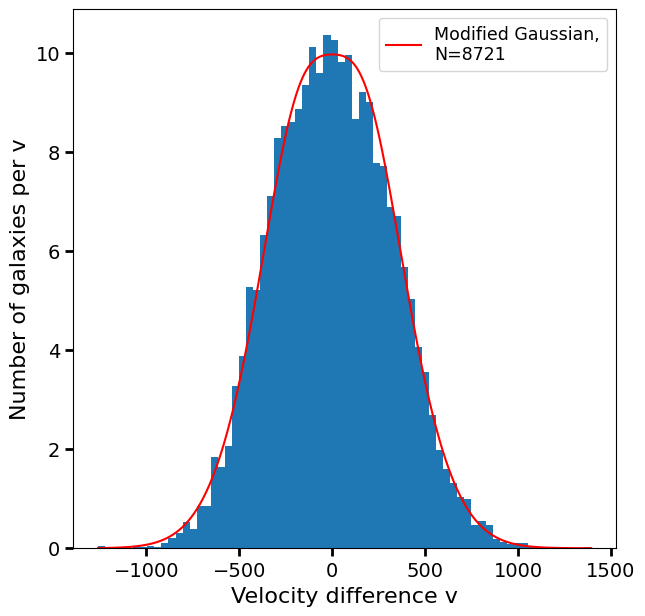

In [13]:
result_gaussian_mod_47 = fit_modified_gaussian(
    data=vel_47,
    bins=70,
    initial_guess=[700, 100, -0.02],
    bounds=[(0.01, None), (0.0001, None), (-0.09, 1)],
    neg_log_likelihood_func=mod_gaussian_neg_log_likelihood_binned,
    plot_func=plot_distribution_gaussian_mod,
    dist_func=mod_gaussian,
    distname='Modified Gaussian',
    binno='47'
)

Optimized parameters: [4.12599061e+02 7.28073419e+01 2.09656213e-01]
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -6395515.881950492
        x: [ 4.126e+02  7.281e+01  2.097e-01]
      nit: 19
      jac: [ 1.863e-01  1.863e-01 -3.260e+00]
     nfev: 96
     njev: 24
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
21594
21594.0


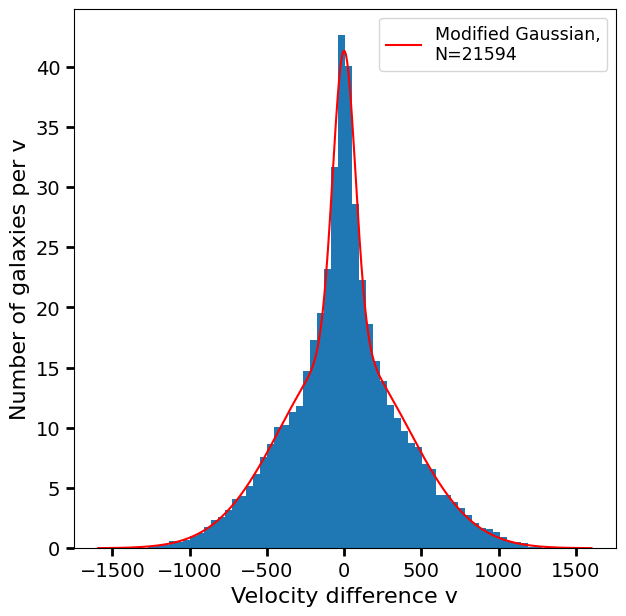

In [14]:
#without using the functions - repeat for all of the velocity arrays above!
bin_heights_01, bin_edges_01 = np.histogram(vel_01, bins=70, density=False)
bin_centers_01 = (bin_edges_01[:-1] + bin_edges_01[1:]) / 2
bin_width_01= bin_edges_01[1] - bin_edges_01[0] 

initial_guess_mod_gauss=[300,100,0.5]
result_gaussian_mod_01= minimize(mod_gaussian_neg_log_likelihood_binned, initial_guess_mod_gauss, args=(bin_edges_01, bin_heights_01, bin_width_01),bounds=[(0.0000000001,None),(0.0000000001,None),(0.1,None)])
print("Optimized parameters:", result_gaussian_mod_01.x)
print(result_gaussian_mod_01)
plot_distribution_gaussian_mod(mod_gaussian,result_gaussian_mod_01.x,vel_01,bins=70
                               ,distname='Modified Gaussian',binno='01')


In [26]:
pos = result_gaussian_mod_01.x + 1e-4 * np.random.randn(32, 3)
pos.shape, result_gaussian_mod_01.x.shape
result_gaussian_mod_01.x

array([4.12599061e+02, 7.28073419e+01, 2.09656213e-01])

Optimized parameters: [3.95894481e+02 8.39519258e+01 6.84462842e-02]
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -8480153.583330197
        x: [ 3.959e+02  8.395e+01  6.845e-02]
      nit: 23
      jac: [ 3.725e-01 -3.725e-01  2.254e+01]
     nfev: 140
     njev: 35
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
37224
37224.0


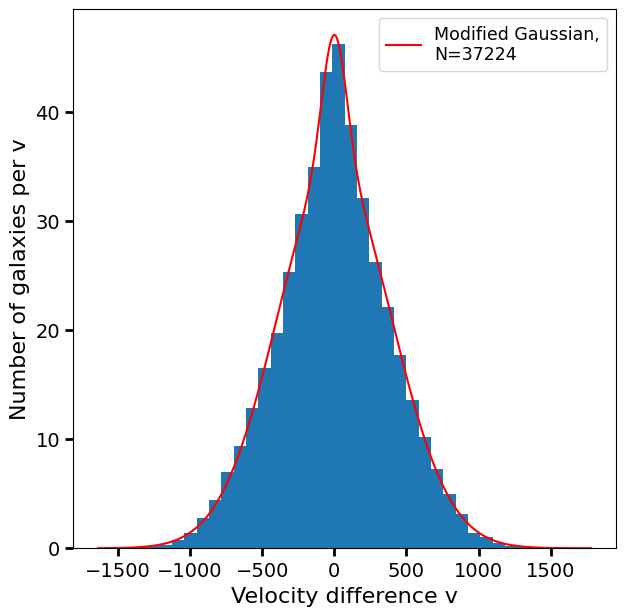

In [15]:
bin_heights_07, bin_edges_07 = np.histogram(vel_07, bins=100, density=False)
bin_centers_07 = (bin_edges_07[:-1] + bin_edges_07[1:]) / 2
bin_width_07= bin_edges_07[1] - bin_edges_07[0] 

initial_guess_mod_gauss=[300,100,0.5]
result_gaussian_mod_07= minimize(mod_gaussian_neg_log_likelihood_binned, initial_guess_mod_gauss, args=(bin_edges_07, bin_heights_07, bin_width_07),bounds=[(0.0000000001,None),(0.0000000001,None),(-100,None)])
print("Optimized parameters:", result_gaussian_mod_07.x)
print(result_gaussian_mod_07)
plot_distribution_gaussian_mod(mod_gaussian,result_gaussian_mod_07.x,vel_07,bins=40
                               ,distname='Modified Gaussian',binno='07')


# [ 3.959e+02  8.404e+01  6.849e-02]

Plotting kurtosis of model with best-fit parameters vs scale:

In [16]:

results=np.asarray([result_gaussian_mod_01.x,result_gaussian_mod_07.x,result_gaussian_mod_10.x, result_gaussian_mod_11.x,result_gaussian_mod_12.x,result_gaussian_mod_13.x,
                    result_gaussian_mod_14.x,result_gaussian_mod_15.x,result_gaussian_mod_16.x,result_gaussian_mod_17.x,result_gaussian_mod_20.x,result_gaussian_mod_23.x,
                    result_gaussian_mod_25.x,
                    result_gaussian_mod_27.x,result_gaussian_mod_30.x,result_gaussian_mod_40.x,result_gaussian_mod_45.x,result_gaussian_mod_47.x,result_gaussian_mod_50.x,])

print(results[:,0])
results
r_bins=[(0,0.1),(0.1,0.2),(0.2,0.23),(0.23,0.29),(0.29,0.32),(0.32,0.36),(0.36,0.4),(0.4,0.5),(0.5,0.6),(0.6,0.8),(0.8,0.1),(1,1.2),(1.2,1.4), (1.4,1.6),(1.6,1.8),(1.8,2.0),(2,2.2),(2.2,2.7),(2.7,5)]

NameError: name 'result_gaussian_mod_10' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def kurtosis_vs_radius(r_bins, lambdas, sigma, sigma1, plot=True):
    """
    Computes and plots excess kurtosis of a weighted sum of two Gaussians vs radius.
    
    Input:
        r_bins : List of (r_min, r_max) of all radial bins
        lambdas : Lambda values for all radial bins.
        sigma : Sigma values for all radial bins
        sigma1 : Sigma1 values for all radial bins
        plot : bool. Whether to plot excess kurtosis vs radius or not

    Returns:
        r_centers :  Bin centers
        excess_kurtosis : Excess kurtosis values for each radial bin
    """
    # bin centers
    r_centers = np.array([(r_min + r_max) / 2 for r_min, r_max in r_bins])
    lambdas = np.array(lambdas)

    # Variance and 4th moment of model
    var_mix = lambdas * sigma1**2 + (1 - lambdas) * sigma**2
    m4_mix = lambdas * 3 * sigma1**4 + (1 - lambdas) * 3 * sigma**4
    excess_kurtosis = m4_mix / var_mix**2 

    if plot==True:
        plt.figure(figsize=(8, 5))
        plt.plot(r_centers, excess_kurtosis, 'o-', color='navy')

        plt.xlabel("Radius $r$ ", size=14)
        plt.ylabel(" Kurtosis",size=14)
 
        plt.tick_params(axis='both', which='major',length=6, width=2,labelsize=14) 
        plt.grid(True, linestyle=':')
        plt.tight_layout()
        # plt.savefig("Kurtosis_1halo.pdf", dpi=300)
        plt.show()

    return r_centers, excess_kurtosis

kurtosis_vs_radius(r_bins,results[:,2], results[:,0], results[:,1])

NameError: name 'r_bins' is not defined

So many codeblocks are inefficient or chunky haha, can definitely be improved!! I would suggest trying MCMC fitting routines instead of minimize :))